In [1]:
import pandas as pd
import numpy as np
import warnings
import math
from tqdm import tqdm
from statistics import mean
from IPython.display import display
from functools import reduce
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
warnings.filterwarnings('ignore')
pio.renderers.default = 'jupyterlab'

# Data

In [2]:
df_prq = pd.read_csv(r"C:\Users\NadirZeynalli\Desktop\SPP\data\df_prq_trndplot.csv")
df_prq

,well,FORMATION,DEPTH,TVD_SCS,TST,Fluidcode_mod,gross_pay,PHIT,LPERM
0,A01,Balakhany,2096.500000,2031.580,0.000000,0,0,0.0,0.0
1,A01,Balakhany,2096.600098,2031.676,0.000000,0,0,0.0,0.0
2,A01,Balakhany,2096.699951,2031.772,0.000000,0,0,0.0,0.0
3,A01,Balakhany,2096.800049,2031.868,0.000000,0,0,0.0,0.0
4,A01,Balakhany,2096.899902,2031.964,0.000000,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
5273507,J32,Balakhany X 20,4353.500000,2493.694,1928.895000,0,0,0.0,0.0
5273508,J32,Balakhany X 20,4353.600000,2493.733,1928.920538,0,0,0.0,0.0
5273509,J32,Balakhany X 20,4353.700000,2493.772,1928.946076,0,0,0.0,0.0
5273510,J32,Balakhany X 20,4353.800000,2493.811,1928.971614,0,0,0.0,0.0


In [3]:
def phit_to_perm(PHI, type):
    if type == 'up':
        PHI += 0.01
    elif type == 'down':
        PHI -= 0.01
        
    if PHI >=0.20: # EQ5
        PERM = (7.7925*((PHI*100)**2))-(29881.0*PHI)+2891.8
        
    elif PHI >= 0.19 and PHI < 0.20:  # EQ4
        PERM = 0.00000002*(math.exp(PHI*105.56))
        
    elif PHI >= 0.16 and PHI < 0.19:  # EQ3
        PERM = 0.00000002*(math.exp(PHI*105.56))
        
    elif PHI >= 0.15 and PHI < 0.16:#EQ2
        PERM = 0.0159*(math.exp(PHI*21.27))
         
    else:
        PERM = 0.0159*(math.exp(PHI*21.27))
        
    return PERM

In [4]:
df_prq = df_prq[df_prq['well']=='A22'][df_prq['Fluidcode_mod']!=0]
df_prq.drop(columns=['LPERM'], inplace=True)

df_prq['PERM_base'] = df_prq['PHIT'].apply(lambda row: phit_to_perm(row, type='base'))
df_prq['PERM_up'] = df_prq['PHIT'].apply(lambda row: phit_to_perm(row, type='up'))
df_prq['PERM_down'] = df_prq['PHIT'].apply(lambda row: phit_to_perm(row, type='down'))

df_prq

,well,FORMATION,DEPTH,TVD_SCS,TST,Fluidcode_mod,gross_pay,PHIT,PERM_base,PERM_up,PERM_down
789476,A22,Balakhany IX,4382.3,2893.571,941.498439,3,1,0.180000,3.572503,10.266297,1.243172
789477,A22,Balakhany IX,4382.4,2893.657,941.560947,3,1,0.171902,1.519624,4.366941,0.528804
789478,A22,Balakhany IX,4382.5,2893.744,941.623448,3,1,0.175652,2.257600,6.487661,0.785608
789479,A22,Balakhany IX,4382.6,2893.831,941.685943,3,1,0.167880,0.993950,2.856314,0.456888
789480,A22,Balakhany IX,4382.7,2893.917,941.748430,3,1,0.167554,0.960308,2.759635,0.453729
...,...,...,...,...,...,...,...,...,...,...,...
792714,A22,Balakhany X 20,4706.1,3157.606,1119.393034,3,1,0.200489,33.249091,54.693853,10.810262
792715,A22,Balakhany X 20,4706.2,3157.686,1119.444564,3,1,0.188804,9.049042,26.004222,3.148918
792716,A22,Balakhany X 20,4706.3,3157.766,1119.496085,3,1,0.160380,0.450328,1.294108,0.389518
792717,A22,Balakhany X 20,4706.4,3157.846,1119.547597,3,1,0.137554,0.296516,0.366794,0.239703


# KH in md

In [5]:
# #KH calculation in MD domain for all wells
# lst = []
# for w in tqdm(df_prq.well.unique()):
#     df_well = df_prq[(df_prq.well == w) & (df_prq.FORMATION.str.contains('Balakhany'))]
#     for f in df_well.FORMATION.unique():
#         df_well_fm = df_well[(df_well.FORMATION == f) & (df_well.Fluidcode_mod != 0)]
#         kh_sum = 0
#         for i in range(len(df_well_fm)):
#             kh_sum += 0.1*df_well_fm.LPERM.iloc[i]
#         lst.append([w, f, round(kh_sum,0)])
# df_res_kh = pd.DataFrame(lst, columns=['well', 'FORMATION', 'KH'])
# df_res_kh

In [6]:
# df_res_kh['KH'].sum()

# KH in tst

In [7]:
#Calculation dataframe with h_tst and avg properties into md
df_prq_tst_init = df_prq[['well', 'DEPTH', 'TST', 'gross_pay', 'FORMATION', 'PERM_base','PERM_up','PERM_down', 'PHIT']]
df_prq_tst_init = df_prq_tst_init[df_prq_tst_init.FORMATION.str.contains('Balakhany') & (df_prq_tst_init.PERM_base !=0)]
df_lst = []
for well_in_loop in tqdm(df_prq_tst_init.well.unique()[:]):
    well_lst = []
    df_prq_tst = df_prq_tst_init[(df_prq_tst_init.well==well_in_loop)]
    for fm in df_prq_tst.FORMATION.unique():
        data = df_prq_tst[df_prq_tst.FORMATION==fm]
        data.iloc[0, 3] = 0
        data.iloc[-1, 3] = 0
        tst_top = [data.iloc[i]['TST'] for i in range(len(data)-1)
                  if (data.iloc[i]['gross_pay'] == 1 and data.iloc[i-1]['gross_pay']==0)]
        tst_bot = [data.iloc[i]['TST'] for i in range(len(data)-1)
                  if (data.iloc[i]['gross_pay'] == 1 and data.iloc[i+1]['gross_pay']==0)]
        h_tst = []
        for k in range(len(tst_top)):
            if (round(tst_top[k],1) == round(tst_bot[k],1)):
                h_tst = 0 
            elif (round(tst_bot[k],1) == round(tst_top[k]+0.1,1)):
                h_tst = 0
            else:
                h_tst = (round((tst_bot[k] - tst_top[k]),1))
                md_perm_base = []
                md_perm_up = []
                md_perm_down = []
                
                md_phit = []
                for i in range(len(data)):
                    if round(data.iloc[i]['TST'],1) >= round(tst_top[k],1) and round(data.iloc[i]['TST'],1) <= round(tst_bot[k],1):
                        md_perm_base.append(data.iloc[i]['PERM_base'])
                        md_perm_up.append(data.iloc[i]['PERM_up'])
                        md_perm_down.append(data.iloc[i]['PERM_down'])
                        
                        md_phit.append(data.iloc[i]['PHIT'])
                        # md_vsh.append(data.iloc[i]['VSH'])
                if len(md_perm_base) == 0:
                    md_perm_base.append(0)
                if len(md_perm_up) == 0:
                    md_perm_up.append(0)
                if len(md_perm_down) == 0:
                    md_perm_down.append(0)
                if len(md_phit) == 0:
                    md_phit.append(0)
            
            well_lst.append([data.iloc[0]['well'], fm, h_tst, round(mean(md_perm_base),1) , round(mean(md_perm_up),1) , round(mean(md_perm_down),1) , round(mean(md_phit),2)])
    df_test_tst = pd.DataFrame(well_lst, columns = ['well', 'FORMATION', 'h_tst', 'md_perm_avg_base','md_perm_avg_up','md_perm_avg_down', 'md_phit_avg'])
    df_lst.append(df_test_tst)
    
df_test_tst

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.77it/s]


,well,FORMATION,h_tst,md_perm_avg_base,md_perm_avg_up,md_perm_avg_down,md_phit_avg
0,A22,Balakhany IX,32.6,116.8,167.0,77.8,0.21
1,A22,Balakhany IX lower shale,18.3,20.4,35.4,9.8,0.18
2,A22,Balakhany X,26.6,44.5,70.0,26.2,0.19
3,A22,Balakhany X sand,33.0,112.4,160.6,75.0,0.21
4,A22,Balakhany X 40,25.2,44.3,71.2,25.7,0.19
5,A22,Balakhany X 20,22.6,4.9,10.4,1.9,0.17


In [8]:
df_test_tst['KH_base_PHIT'] = df_test_tst['h_tst'] * df_test_tst['md_perm_avg_base']
df_test_tst['KH_up_PHIT'] = df_test_tst['h_tst'] * df_test_tst['md_perm_avg_up'] 
df_test_tst['KH_down_PHIT'] = df_test_tst['h_tst'] * df_test_tst['md_perm_avg_down']

df_test_tst['KH_base_TST'] = df_test_tst['h_tst'] * df_test_tst['md_perm_avg_base']
df_test_tst['KH_up_TST'] = (df_test_tst['h_tst'] * 1.1) * df_test_tst['md_perm_avg_base']
df_test_tst['KH_down_TST'] = (df_test_tst['h_tst'] * 0.9) * df_test_tst['md_perm_avg_base']

In [9]:
df_test_tst

,well,FORMATION,h_tst,md_perm_avg_base,md_perm_avg_up,md_perm_avg_down,md_phit_avg,KH_base_PHIT,KH_up_PHIT,KH_down_PHIT,KH_base_TST,KH_up_TST,KH_down_TST
0,A22,Balakhany IX,32.6,116.8,167.0,77.8,0.21,3807.68,5444.20,2536.28,3807.68,4188.448,3426.912
1,A22,Balakhany IX lower shale,18.3,20.4,35.4,9.8,0.18,373.32,647.82,179.34,373.32,410.652,335.988
2,A22,Balakhany X,26.6,44.5,70.0,26.2,0.19,1183.70,1862.00,696.92,1183.70,1302.070,1065.330
3,A22,Balakhany X sand,33.0,112.4,160.6,75.0,0.21,3709.20,5299.80,2475.00,3709.20,4080.120,3338.280
4,A22,Balakhany X 40,25.2,44.3,71.2,25.7,0.19,1116.36,1794.24,647.64,1116.36,1227.996,1004.724
5,A22,Balakhany X 20,22.6,4.9,10.4,1.9,0.17,110.74,235.04,42.94,110.74,121.814,99.666


# Tornado plot

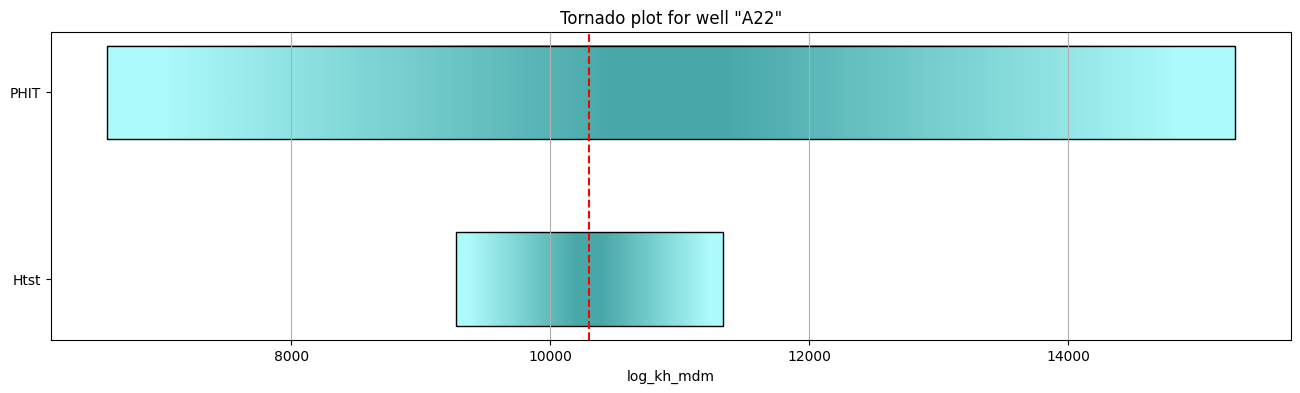

In [10]:
df = df_test_tst

# Calculating boundaries
tst_min = df['KH_down_TST'].sum()
tst_max = df['KH_up_TST'].sum()
tst_base = df['KH_base_TST'].sum()
tst_range = tst_max - tst_min

phit_min = df['KH_down_PHIT'].sum()
phit_max = df['KH_up_PHIT'].sum()
phit_base = df['KH_base_PHIT'].sum()
phit_range = phit_max - phit_min

# Generating dataframe for final outputs
well_name = df['well'].unique()[0]
arr = [[tst_min,tst_max,tst_range,'Htst'],
       [phit_min,phit_max,phit_range,'PHIT']]

df_new = pd.DataFrame(arr,columns=['Minimum','Maximum','Range','Parameter'])
df_new['well'] = well_name
df_new.sort_values('Range', inplace=True)
df_new.reset_index(inplace=True)
df_new.drop('index',axis=1,inplace=True)

# Visalization
def hor_gradient_image(ax, extent, darkest, **kwargs):
    '''
    puts a horizontal gradient in the rectangle defined by extent (x0, x1, y0, y1)
    darkest is a number between 0 (left) and 1 (right) setting the spot where the gradient will be darkest
    '''
    ax = ax or plt.gca()
    img = np.interp(np.linspace(0, 1, 10), [0, darkest, 1], [0, 1, 0]).reshape(1, -1)
    return ax.imshow(img, extent=extent, interpolation='bilinear', vmin=0, vmax=1, **kwargs)

def gradient_hbar(y, x0, x1, ax=None, height=0.5, darkest=0.5, cmap=plt.cm.Blues):
    hor_gradient_image(ax, extent=(x0, x1, y - height / 2, y + height / 2), cmap=cmap, darkest=darkest)
    rect = mpatches.Rectangle((x0, y - height / 2), x1 - x0, height, edgecolor='black', facecolor='none')
    ax.add_patch(rect)

cmap = mcolors.LinearSegmentedColormap.from_list('turq', ['#ACFAFA', '#3C9E9E'])

fig, ax = plt.subplots()

for i in range(2):
    x0, x1 = df_new.iloc[i,0], df_new.iloc[i,1]
    gradient_hbar(i, x0, x1, ax=ax, height=0.5, darkest=0.5, cmap=cmap)
    
params = df_new['Parameter'].to_list()
ys = [i for i in range(len(params))]

fig.set_size_inches(16,4)
ax.yaxis.set_ticks(ys)
ax.set_aspect('auto')
ax.use_sticky_edges = False
ax.autoscale(enable=True, tight=False)
ax.set_yticklabels(params)
ax.set_xlabel('log_kh_mdm')
ax.set_title(f'Tornado plot for well "{well_name}"')
ax.grid(axis='x')
ax.axvline(x=phit_base, color='red', linestyle='--')
plt.show()

fig.savefig(rf'C:\Users\NadirZeynalli\Desktop\tornado_{well_name}.jpg')